In [1]:
# Importing the necessary libraries
import json
import os
from PIL import Image
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from tqdm import tqdm

In [2]:
# Define the image transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [3]:
# Defining ImageDataset Class
class ImageDataset(Dataset):
    def __init__(self, image_dir, info_file, transform=None):
        self.image_dir = image_dir
        self.image_paths = []
        self.labels = []
        self.label_to_idx = {}
        
        with open(info_file, 'r') as f:
            info = json.load(f)
        
        # Create a mapping from labels to integers
        unique_labels = set(info.values())
        for idx, label in enumerate(unique_labels):
            self.label_to_idx[label] = idx
        
        for image_path, label in info.items():
            self.image_paths.append(os.path.join(image_dir, image_path))
            self.labels.append(self.label_to_idx[label])  # Convert label to integer using the mapping
        
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        try:
            image = Image.open(image_path).convert('RGB')
        except FileNotFoundError:
            # Return a default value or handle the missing file appropriately
            return torch.zeros(3, 224, 224), 0  # Replace with your desired default value

        if self.transform:
            image = self.transform(image)
        label = self.labels[idx]
        return image, label


In [4]:
# Define the contrastive loss function
class ContrastiveLoss(nn.Module):
    def __init__(self, margin=1.0, eps=1e-6):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin
        self.eps = eps

    def forward(self, x1, x2, y):
        distances = torch.sqrt(((x1 - x2) ** 2).sum(dim=1) + self.eps)  # Add eps inside sqrt
        losses = y * distances ** 2 + (1 - y) * torch.clamp(self.margin - distances, min=0.0) ** 2
        return losses.mean()

In [5]:
# Define the image similarity model
class ImageSimilarityModel(nn.Module):
    def __init__(self):
        super(ImageSimilarityModel, self).__init__()
        self.backbone = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=2, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(128, 256, kernel_size=3, stride=2, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(256, 512, kernel_size=3, stride=2, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.fc = nn.Linear(512 * 1 * 1, 128)

    def forward(self, x):
        x = self.backbone(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

In [6]:
# Load the dataset
train_dataset = ImageDataset('train/', 'train_image_info.json', transform=transform)
query_dataset = ImageDataset('query_images/', 'test_image_info.json', transform=transform)
gallery_dataset = ImageDataset('gallery/', 'test_image_info.json', transform=transform)

In [7]:
# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
query_loader = DataLoader(query_dataset, batch_size=1, shuffle=False)
gallery_loader = DataLoader(gallery_dataset, batch_size=1, shuffle=False)

In [8]:
# Initialize the model and optimizer
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = ImageSimilarityModel().to(device)
criterion = ContrastiveLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)  # Reduced learning rate
num_epochs = 20

In [9]:
# Initialize lists to store the training loss
train_losses = []

for epoch in range(num_epochs):
    running_loss = 0.0
    for images, labels in tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs}'):
        images = images.to(device)
        labels = torch.tensor(labels).to(device)

        optimizer.zero_grad()
        embeddings = model(images)

        # Create matching and non-matching pairs
        batch_size = embeddings.size(0)
        y = torch.eye(batch_size).to(device)
        y = y.view(-1)

        anchor_embeddings = embeddings.repeat(batch_size, 1)
        positive_embeddings = embeddings.repeat(1, batch_size).view(-1, embeddings.size(-1))

        loss = criterion(anchor_embeddings, positive_embeddings, y)
        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

        optimizer.step()

        running_loss += loss.item()
    epoch_loss = running_loss / len(train_loader)
    train_losses.append(epoch_loss)
    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss}')

Epoch 1/20:   0%|                                       | 0/358 [00:00<?, ?it/s]/var/folders/gp/22ysvrsd0ql27jjdhcp06wg00000gn/T/ipykernel_37564/3305592083.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).to(device)
Epoch 1/20: 100%|█████████████████████████████| 358/358 [03:50<00:00,  1.56it/s]


Epoch 1/20, Loss: 0.0020678978830957996


Epoch 2/20: 100%|█████████████████████████████| 358/358 [03:54<00:00,  1.53it/s]


Epoch 2/20, Loss: 3.130973211298182e-08


Epoch 3/20: 100%|█████████████████████████████| 358/358 [04:04<00:00,  1.46it/s]


Epoch 3/20, Loss: 3.130973211298182e-08


Epoch 4/20: 100%|█████████████████████████████| 358/358 [04:10<00:00,  1.43it/s]


Epoch 4/20, Loss: 3.130973211298182e-08


Epoch 5/20: 100%|█████████████████████████████| 358/358 [04:01<00:00,  1.48it/s]


Epoch 5/20, Loss: 5.476060695985705e-06


Epoch 6/20: 100%|█████████████████████████████| 358/358 [03:41<00:00,  1.61it/s]


Epoch 6/20, Loss: 5.476060695985705e-06


Epoch 7/20: 100%|█████████████████████████████| 358/358 [04:02<00:00,  1.47it/s]


Epoch 7/20, Loss: 5.476060695985705e-06


Epoch 8/20: 100%|█████████████████████████████| 358/358 [03:52<00:00,  1.54it/s]


Epoch 8/20, Loss: 3.130973211298182e-08


Epoch 9/20: 100%|█████████████████████████████| 358/358 [03:52<00:00,  1.54it/s]


Epoch 9/20, Loss: 3.130973211298182e-08


Epoch 10/20: 100%|████████████████████████████| 358/358 [03:50<00:00,  1.55it/s]


Epoch 10/20, Loss: 3.130973211298182e-08


Epoch 11/20: 100%|████████████████████████████| 358/358 [04:00<00:00,  1.49it/s]


Epoch 11/20, Loss: 3.130973211298182e-08


Epoch 12/20: 100%|████████████████████████████| 358/358 [04:22<00:00,  1.36it/s]


Epoch 12/20, Loss: 3.130973211298182e-08


Epoch 13/20: 100%|████████████████████████████| 358/358 [04:01<00:00,  1.48it/s]


Epoch 13/20, Loss: 3.130973211298182e-08


Epoch 14/20: 100%|████████████████████████████| 358/358 [03:53<00:00,  1.53it/s]


Epoch 14/20, Loss: 5.476061021168168e-06


Epoch 15/20: 100%|████████████████████████████| 358/358 [03:40<00:00,  1.62it/s]


Epoch 15/20, Loss: 3.130973211298182e-08


Epoch 16/20: 100%|████████████████████████████| 358/358 [03:39<00:00,  1.63it/s]


Epoch 16/20, Loss: 3.130973211298182e-08


Epoch 17/20: 100%|████████████████████████████| 358/358 [03:42<00:00,  1.61it/s]


Epoch 17/20, Loss: 3.130973211298182e-08


Epoch 18/20: 100%|████████████████████████████| 358/358 [03:40<00:00,  1.63it/s]


Epoch 18/20, Loss: 3.130973211298182e-08


Epoch 19/20: 100%|████████████████████████████| 358/358 [04:01<00:00,  1.48it/s]


Epoch 19/20, Loss: 5.476060695985705e-06


Epoch 20/20: 100%|████████████████████████████| 358/358 [04:15<00:00,  1.40it/s]

Epoch 20/20, Loss: 3.130973211298182e-08


In [10]:

# Compute embeddings for query and gallery images
query_embeddings = []
gallery_embeddings = []

with torch.no_grad():
    for query_image, _ in tqdm(query_loader, desc='Computing query embeddings'):
        query_image = query_image.to(device)
        embedding = model(query_image)
        query_embeddings.append(embedding)

    for gallery_image, _ in tqdm(gallery_loader, desc='Computing gallery embeddings'):
        gallery_image = gallery_image.to(device)
        embedding = model(gallery_image)
        gallery_embeddings.append(embedding)



Computing gallery embeddings: 100%|████████| 1150/1150 [00:09<00:00, 121.75it/s]


In [13]:
# Convert embeddings to tensors
query_embeddings = torch.cat(query_embeddings, dim=0)
gallery_embeddings = torch.cat(gallery_embeddings, dim=0)

# Compute similarity scores and rank the gallery images
ranks = []
for query_embedding in tqdm(query_embeddings, desc='Ranking gallery images'):
    similarities = torch.mm(gallery_embeddings, query_embedding.unsqueeze(1)).squeeze()
    sorted_indices = torch.argsort(similarities, descending=True)
    ranks.append(sorted_indices)


Ranking gallery images: 100%|████████████| 1150/1150 [00:00<00:00, 14205.92it/s]


In [14]:
# Compute evaluation metrics
mAP_1 = 0.0
mAP_10 = 0.0
mAP_50 = 0.0
mean_rank = 0.0

for i, rank in enumerate(ranks):
    query_label = query_dataset.labels[i]
    gallery_labels = [gallery_dataset.labels[idx.item()] for idx in rank]

    # Compute mAP@1
    if gallery_labels[0] == query_label:
        mAP_1 += 1.0

    # Compute mAP@10
    precision_at_10 = sum(1 for label in gallery_labels[:10] if label == query_label) / 10
    mAP_10 += precision_at_10

    # Compute mAP@50
    precision_at_50 = sum(1 for label in gallery_labels[:50] if label == query_label) / 50
    mAP_50 += precision_at_50

    # Compute mean rank
    rank_of_first_match = next((i for i, label in enumerate(gallery_labels) if label == query_label), len(gallery_labels))
    mean_rank += rank_of_first_match

      
mAP_1 /= len(ranks)
mAP_10 /= len(ranks)
mAP_50 /= len(ranks)
mean_rank /= len(ranks)

print(f'mAP@1: {mAP_1}')
print(f'mAP@10: {mAP_10}')
print(f'mAP@50: {mAP_50}')
print(f'Mean Rank: {mean_rank}')

mAP@1: 0.06869565217391305
mAP@10: 0.06678260869565214
mAP@50: 0.06679999999999993
Mean Rank: 22.863478260869567


In [ ]:
import matplotlib.pyplot as plt

def plot_query_with_topk(query_image, topk_images, topk_scores, k=5):
    fig, axes = plt.subplots(1, k + 1, figsize=(15, 5))
    
    # Plot the query image
    axes[0].imshow(query_image.permute(1, 2, 0).cpu().numpy())
    axes[0].set_title("Query Image")
    axes[0].axis('off')
    
    # Plot the top-k gallery images
    for i in range(k):
        axes[i + 1].imshow(topk_images[i].permute(1, 2, 0).cpu().numpy())
        axes[i + 1].set_title(f"Rank {i+1}\nScore: {topk_scores[i]:.2f}")
        axes[i + 1].axis('off')
    
    plt.show()

def visualize_results(query_loader, gallery_loader, model, device, k=5):
    model.eval()
    query_embeddings = []
    query_images = []
    gallery_embeddings = []
    gallery_images = []

    with torch.no_grad():
        for query_image, _ in tqdm(query_loader, desc='Computing query embeddings'):
            query_image = query_image.to(device)
            embedding = model(query_image)
            query_embeddings.append(embedding)
            query_images.append(query_image.squeeze().cpu())

        for gallery_image, _ in tqdm(gallery_loader, desc='Computing gallery embeddings'):
            gallery_image = gallery_image.to(device)
            embedding = model(gallery_image)
            gallery_embeddings.append(embedding)
            gallery_images.append(gallery_image.squeeze().cpu())

    query_embeddings = torch.cat(query_embeddings, dim=0)
    gallery_embeddings = torch.cat(gallery_embeddings, dim=0)

    # Compute similarity scores and visualize top-k results
    for i, query_embedding in enumerate(tqdm(query_embeddings, desc='Visualizing results')):
        similarities = torch.mm(gallery_embeddings, query_embedding.unsqueeze(1)).squeeze()
        sorted_indices = torch.argsort(similarities, descending=True)
        
        topk_indices = sorted_indices[:k]
        topk_images = [gallery_images[idx] for idx in topk_indices]
        topk_scores = similarities[topk_indices].cpu().numpy()
        
        plot_query_with_topk(query_images[i], topk_images, topk_scores, k)

# Run the visualization function
visualize_results(query_loader, gallery_loader, model, device, k=5)

# NOTE: # the results of this cell were too large for this file to be uploaded on github
        # so some of the similarity exmaples are shown in the report.


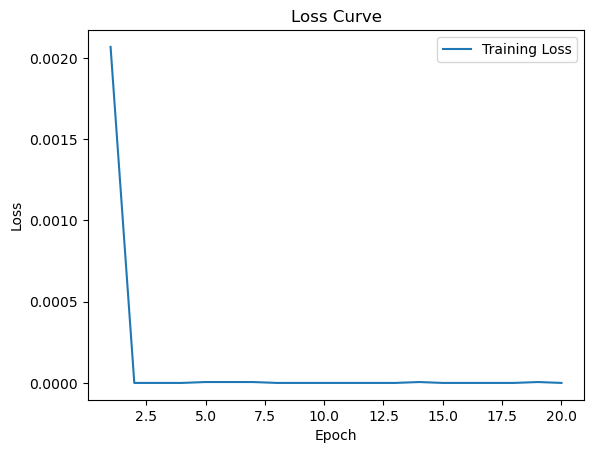

In [16]:
import matplotlib.pyplot as plt


# Plot the loss curve
plt.figure()
plt.plot(range(1, num_epochs+1), train_losses, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Curve')
plt.legend()
plt.show()


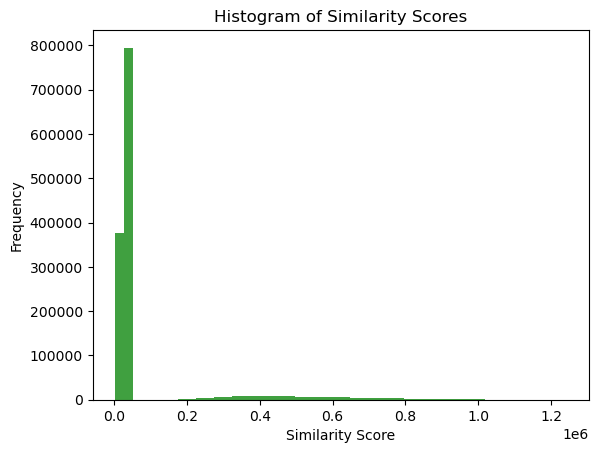

In [17]:
import numpy as np

# Compute similarity scores between query and gallery embeddings
similarity_scores = []
for query_embedding in query_embeddings:
    similarities = torch.mm(gallery_embeddings, query_embedding.unsqueeze(1)).squeeze().cpu().numpy()
    similarity_scores.extend(similarities)

# Plot the histogram of similarity scores
plt.figure()
plt.hist(similarity_scores, bins=50, alpha=0.75, color='g')
plt.xlabel('Similarity Score')
plt.ylabel('Frequency')
plt.title('Histogram of Similarity Scores')
plt.show()


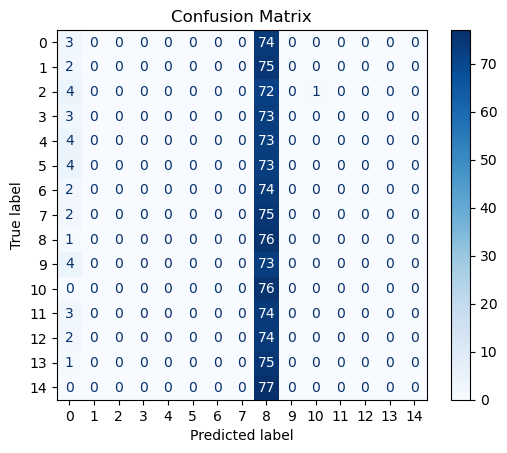

In [18]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Compute the confusion matrix for the top-1 prediction
y_true = []
y_pred = []

for i, rank in enumerate(ranks):
    query_label = query_dataset.labels[i]
    top1_gallery_label = gallery_dataset.labels[rank[0].item()]
    y_true.append(query_label)
    y_pred.append(top1_gallery_label)

cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

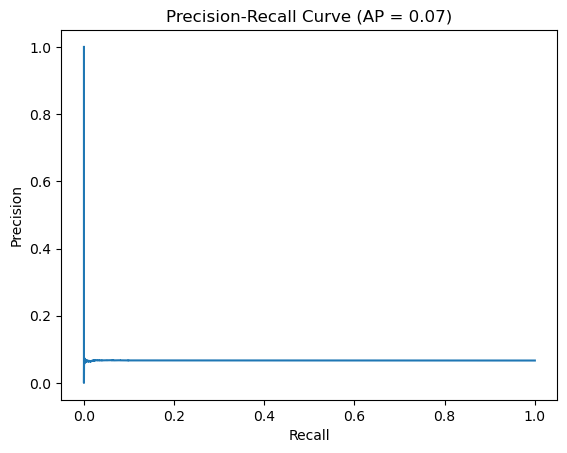

In [19]:
from sklearn.metrics import precision_recall_curve, average_precision_score

# Compute precision-recall curve
y_true_flat = []
y_scores_flat = []

for i, query_embedding in enumerate(query_embeddings):
    similarities = torch.mm(gallery_embeddings, query_embedding.unsqueeze(1)).squeeze()
    similarities_np = similarities.cpu().numpy()
    query_label = query_dataset.labels[i]
    gallery_labels = [gallery_dataset.labels[idx.item()] for idx in torch.argsort(similarities, descending=True)]
    y_true_flat.extend([1 if label == query_label else 0 for label in gallery_labels])
    y_scores_flat.extend(similarities_np)

precision, recall, _ = precision_recall_curve(y_true_flat, y_scores_flat)
average_precision = average_precision_score(y_true_flat, y_scores_flat)

plt.figure()
plt.step(recall, precision, where='post')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title(f'Precision-Recall Curve (AP = {average_precision:.2f})')
plt.show()


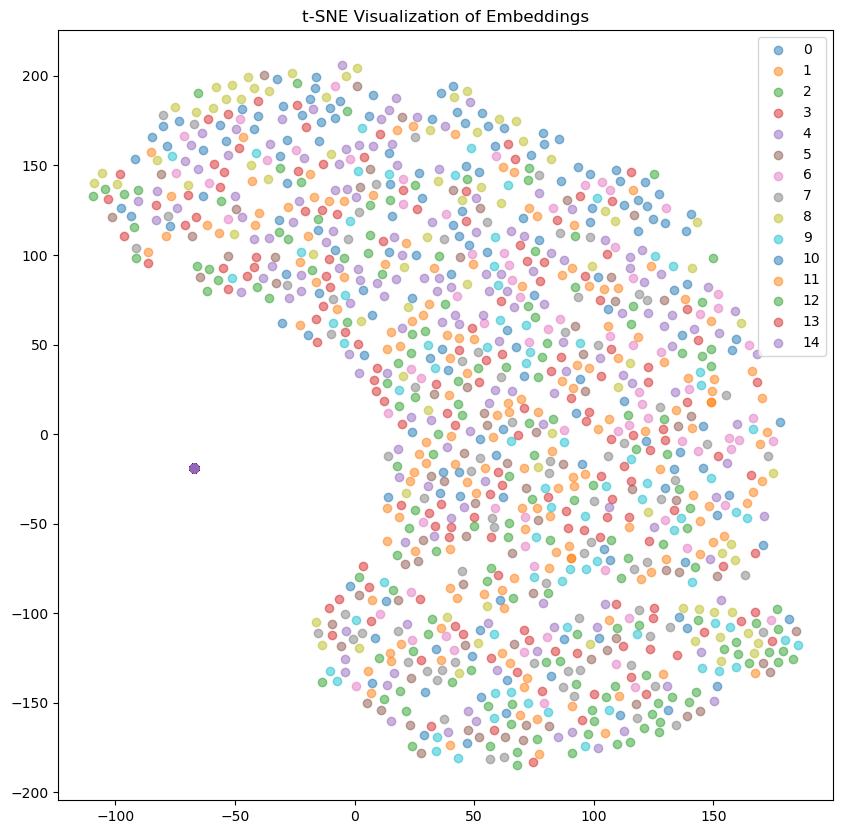

In [20]:
from sklearn.manifold import TSNE

# Compute t-SNE visualization for query and gallery embeddings
all_embeddings = torch.cat((query_embeddings, gallery_embeddings), dim=0).cpu().numpy()
labels = query_dataset.labels + gallery_dataset.labels

tsne = TSNE(n_components=2, random_state=0)
embeddings_2d = tsne.fit_transform(all_embeddings)

# Plot t-SNE embeddings
plt.figure(figsize=(10, 10))
for label in set(labels):
    idxs = [i for i, l in enumerate(labels) if l == label]
    plt.scatter(embeddings_2d[idxs, 0], embeddings_2d[idxs, 1], label=str(label), alpha=0.5)
plt.legend()
plt.title('t-SNE Visualization of Embeddings')
plt.show()

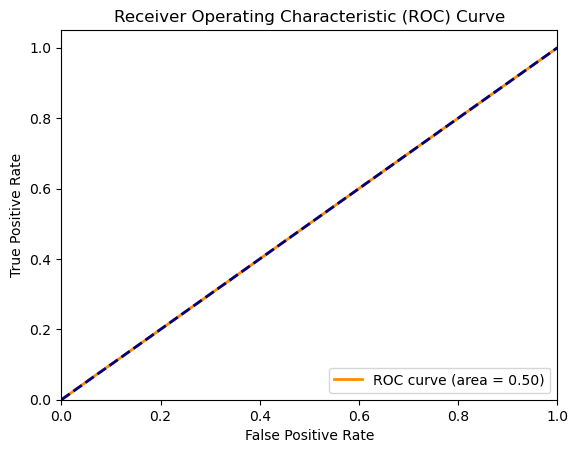

In [22]:
from sklearn.metrics import roc_curve, roc_auc_score

# Compute ROC curve and AUC for the similarity scores
fpr, tpr, _ = roc_curve(y_true_flat, y_scores_flat)
roc_auc = roc_auc_score(y_true_flat, y_scores_flat)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()


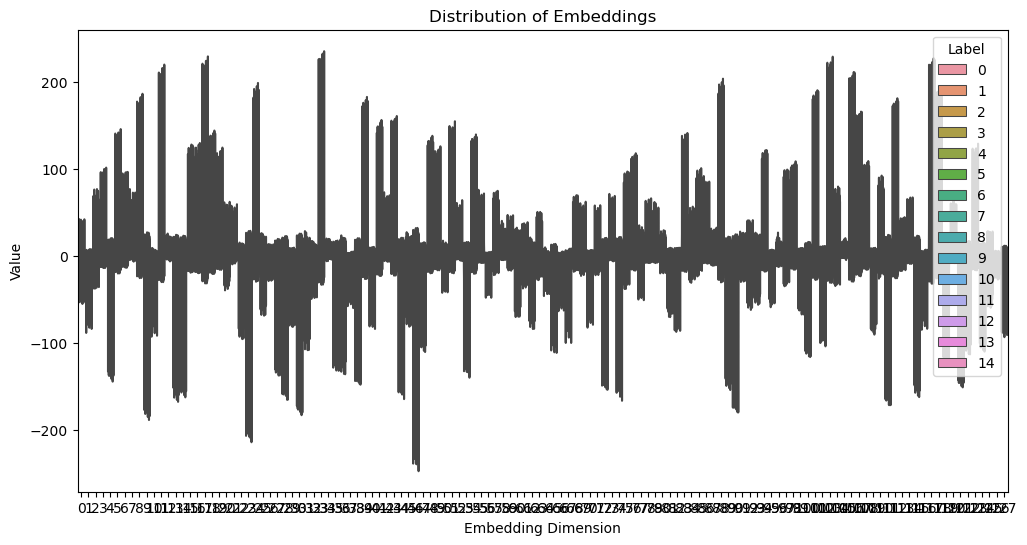

In [28]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

# Create a DataFrame of embeddings with their labels
embeddings_df = pd.DataFrame(query_embeddings.cpu().numpy())
embeddings_df['label'] = query_dataset.labels

# Melt the DataFrame to long format
embeddings_melted = pd.melt(embeddings_df, id_vars=['label'], var_name='Dimension', value_name='Value')

# Plot the violin plot
plt.figure(figsize=(12, 6))
sns.violinplot(x='Dimension', y='Value', hue='label', data=embeddings_melted, inner='quartile')
plt.title('Distribution of Embeddings')
plt.xlabel('Embedding Dimension')
plt.ylabel('Value')
plt.legend(title='Label')
plt.show()


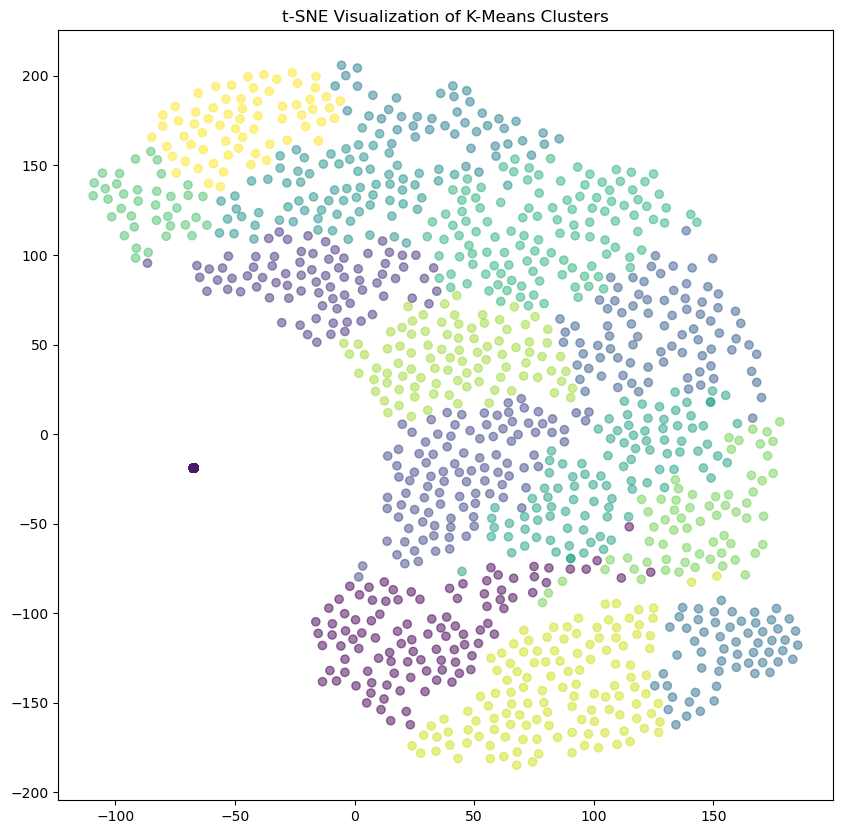

In [24]:
from sklearn.cluster import KMeans

# Apply K-Means clustering to the embeddings
kmeans = KMeans(n_clusters=len(set(labels)), random_state=0)
clusters = kmeans.fit_predict(all_embeddings)

# Visualize the clusters using t-SNE
tsne = TSNE(n_components=2, random_state=0)
embeddings_2d = tsne.fit_transform(all_embeddings)

plt.figure(figsize=(10, 10))
plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], c=clusters, cmap='viridis', alpha=0.5)
plt.title('t-SNE Visualization of K-Means Clusters')
plt.show()


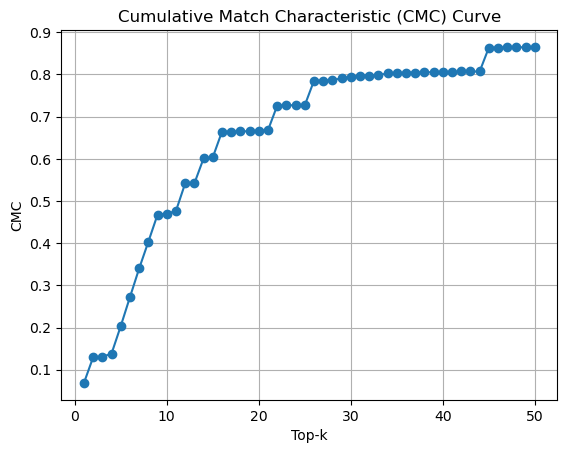

In [25]:
def compute_cmc(ranks, query_labels, gallery_labels, top_k=50):
    cmc = np.zeros(top_k)
    num_queries = len(query_labels)

    for i, rank in enumerate(ranks):
        query_label = query_labels[i]
        for j in range(top_k):
            if gallery_labels[rank[j]] == query_label:
                cmc[j:] += 1
                break

    cmc /= num_queries
    return cmc

# Compute CMC
top_k = 50
cmc = compute_cmc(ranks, query_dataset.labels, gallery_dataset.labels, top_k)

# Plot CMC
plt.figure()
plt.plot(range(1, top_k + 1), cmc, marker='o')
plt.xlabel('Top-k')
plt.ylabel('CMC')
plt.title('Cumulative Match Characteristic (CMC) Curve')
plt.grid(True)
plt.show()
